# Evaluating Model Runs

Purpose of this notebook is to display the results of different tests

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

datapath = Path.home() / "Box/NASA_Figures/data/validation"

plt.style.use("ggplot")

## Show Simulations against validation

In [118]:
model_name = "qr_test38"
sims = pd.read_csv(datapath / f"predictions/{model_name}.csv")
sims

,theta,x,sim_id,valid_id,sim,t,set_id,true_data,train
0,1.053116,0.000000,0.0,0,True,0.000000,0,False,True
1,1.059269,0.003139,0.0,0,True,0.010002,0,False,True
2,1.066257,0.006375,0.0,0,True,0.020004,0,False,True
3,1.073714,0.009476,0.0,0,True,0.030006,0,False,True
4,1.081918,0.012655,0.0,0,True,0.040008,0,False,True
...,...,...,...,...,...,...,...,...,...
2309995,-6.209206,-1.797089,NaN,5,False,49.959992,9,True,False
2309996,-6.211886,-1.778035,NaN,5,False,49.969994,9,True,False
2309997,-6.213567,-1.762000,NaN,5,False,49.979996,9,True,False
2309998,-6.214298,-1.749020,NaN,5,False,49.989998,9,True,False


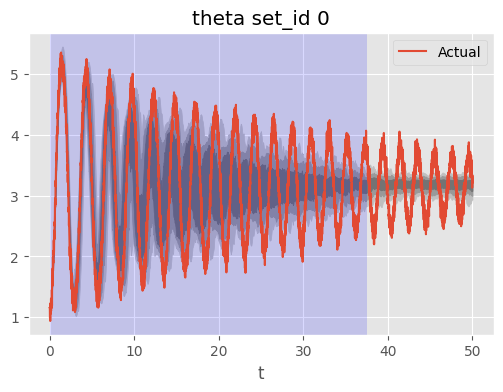

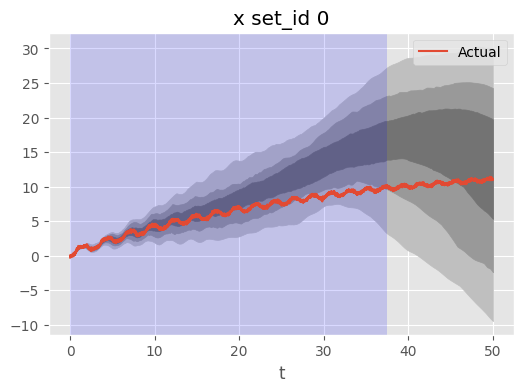

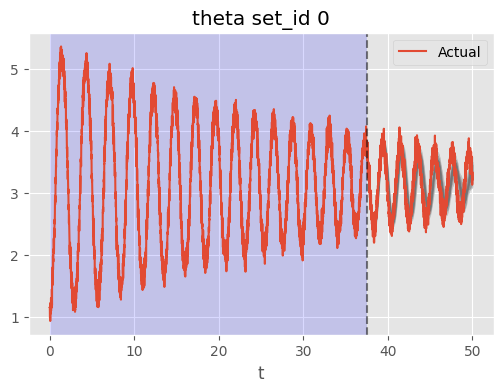

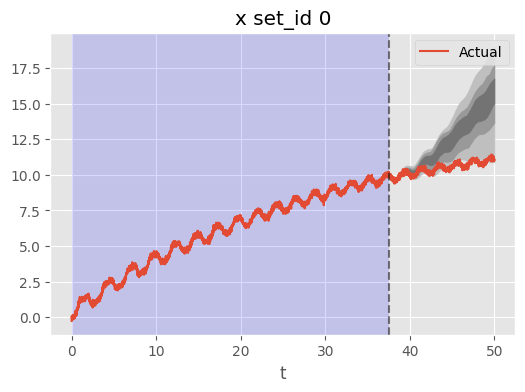

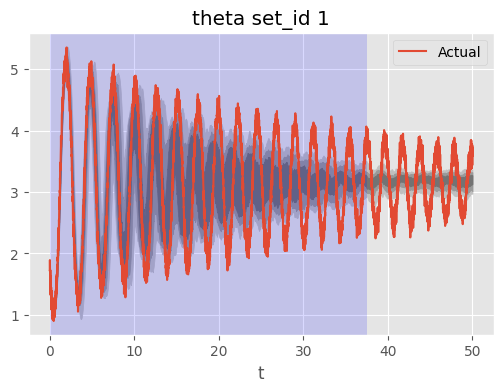

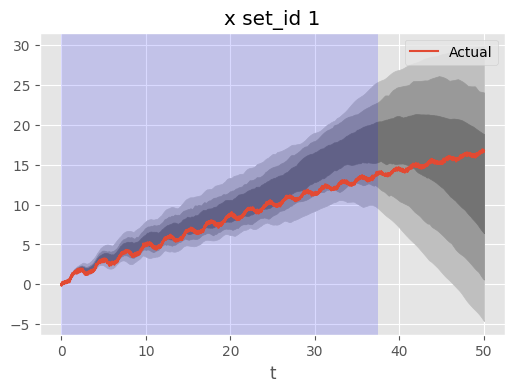

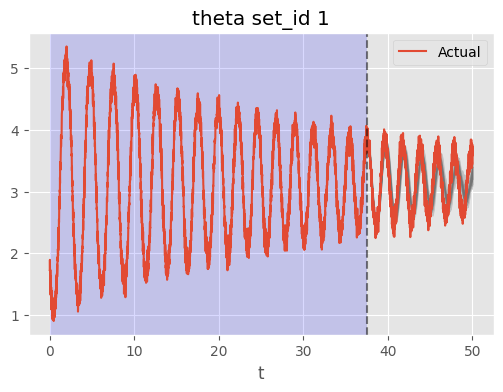

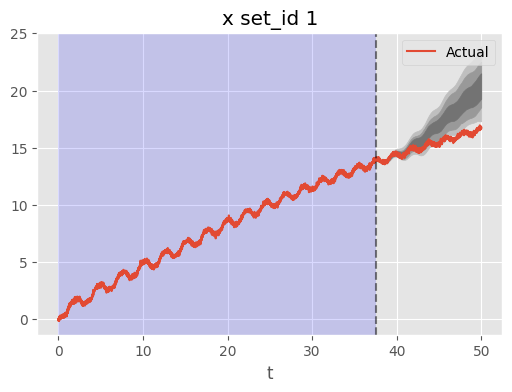

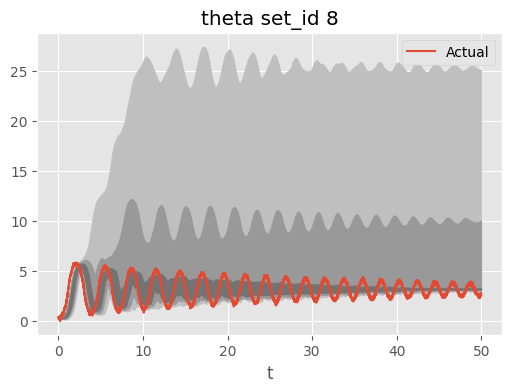

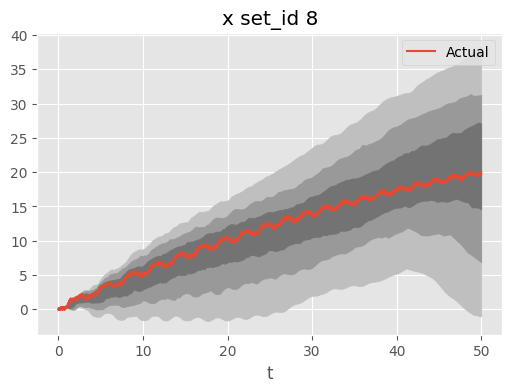

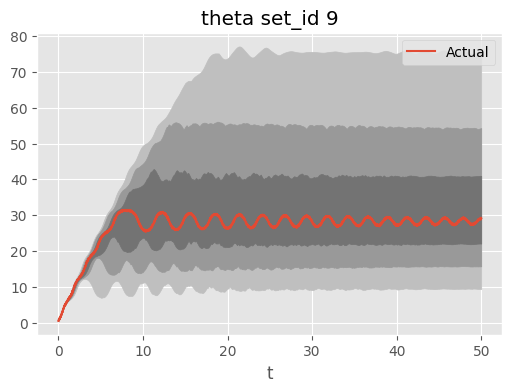

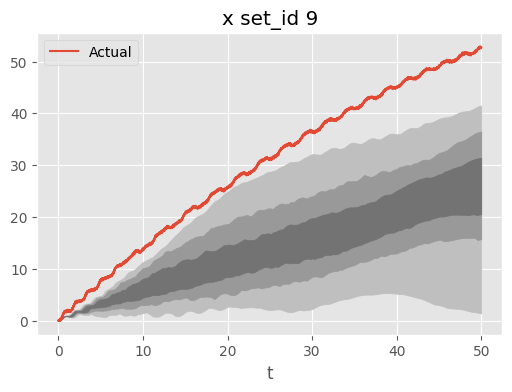

In [119]:
# Pivot sims wide
wide = {}
conf_ints = [0.5, 0.8, 0.95]
for valid_id in sims.valid_id.unique():
    for col in ["theta", "x"]:
        wide[col] = pd.pivot_table(
            sims[sims.sim & (sims.valid_id == valid_id)],
            index="t",
            columns="sim_id",
            values=col,
        )

        # Plot
        fig, ax = plt.subplots(dpi=100)

        # Plot trainspan, if applicable
        tmask = sims.loc[sims.valid_id == valid_id, "train"]
        if tmask.sum() > 0:
            tmin = sims.loc[sims.valid_id == valid_id, "t"][tmask].min()
            tmax = sims.loc[sims.valid_id == valid_id, "t"][tmask].max()
            ax.axvspan(tmin, tmax, alpha=0.15, facecolor="blue")

        # Plot CIs
        for i, a in enumerate(reversed(sorted(conf_ints))):
            a2 = (1 - a) / 2
            ax.fill_between(
                wide[col].index,
                y1=np.quantile(wide[col], a2, axis=1),
                y2=np.quantile(wide[col], 1 - a2, axis=1),
                # alpha=0.25 * (i + 1),
                # color="gray",
                color=str(0.9 - 0.15 * (i + 1)),
                label="",
            )

        # Plot Actuals
        set_id = sims.loc[sims.valid_id == valid_id, "set_id"].iloc[0]
        sims.loc[
            ~sims.sim & (sims.set_id == set_id) & ~sims.true_data, ["t", col]
        ].drop_duplicates().plot(x="t", y=col, label="Actual", ax=ax)

        # Plot where training set ends, if applicable
        if wide[col].index.min() != sims.loc[sims.set_id == set_id, "t"].min():
            ax.axvline(wide[col].index.min(), ls="--", c="k", alpha=0.5)
        ax.set_title(f"{col} set_id {set_id}")
        plt.show()

## Read in and Model and Parameters

In [120]:
# Read in parameters
import json

model_name = "qr_test38"

with open(datapath / f"parameters/{model_name}.json", "r") as f:
    params = json.load(f)
if "dt" not in params:
    params["dt"] = params["model_params"]["dt"]

In [121]:
import pickle

with open(datapath/ f"model_objects/{model_name}.pkl", "rb"
        ) as inp:
    model = pickle.load(inp)

model

<AxesSubplot:>

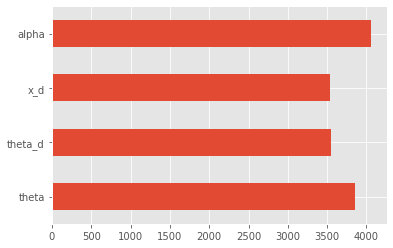

In [122]:

# fi = pd.Series(model.models[1].feature_importance(), index=["theta", "alpha"])
fi = pd.Series(model.models[1].feature_importance(), index=["theta", "theta_d", "x_d", "alpha"])
fi.plot.barh()

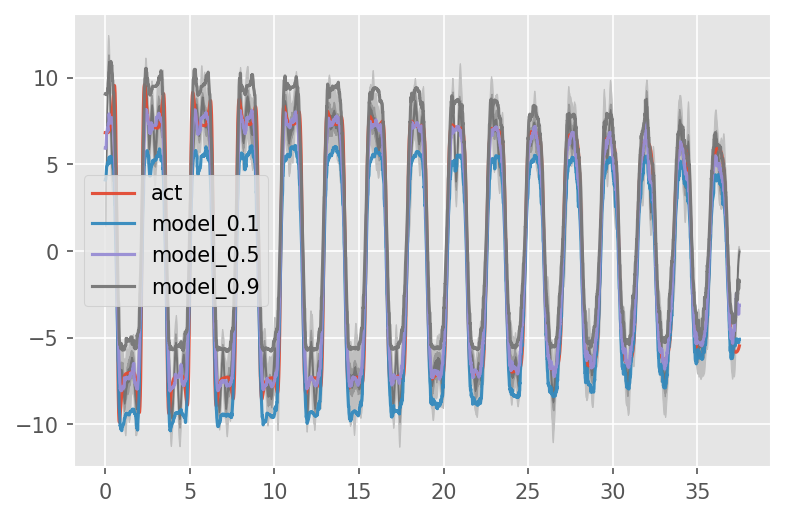

,act,model_0.1,model_0.5,model_0.9,lower_99,lower_80,lower_50,upper_50,upper_80,upper_99
act,1.00,0.99,0.99,0.99,0.98,0.98,0.98,0.98,0.98,0.98
model_0.1,0.99,1.00,1.00,0.99,0.99,0.99,0.99,0.99,0.99,0.99
model_0.5,0.99,1.00,1.00,1.00,0.99,0.99,0.99,0.99,0.99,0.99
model_0.9,0.99,0.99,1.00,1.00,0.99,0.99,0.99,0.99,0.99,0.99
lower_99,0.98,0.99,0.99,0.99,1.00,1.00,1.00,1.00,1.00,1.00
lower_80,0.98,0.99,0.99,0.99,1.00,1.00,1.00,1.00,1.00,1.00
lower_50,0.98,0.99,0.99,0.99,1.00,1.00,1.00,1.00,1.00,1.00
upper_50,0.98,0.99,0.99,0.99,1.00,1.00,1.00,1.00,1.00,1.00
upper_80,0.98,0.99,0.99,0.99,1.00,1.00,1.00,1.00,1.00,1.00
upper_99,0.98,0.99,0.99,0.99,1.00,1.00,1.00,1.00,1.00,1.00


In [123]:
set_id = 0
var = "theta"
idx = ["theta", "x"].index(var)

# Get points per set
dp = params["data_gen_params"]
pps = round((dp["tspan"][1] - dp["tspan"][0]) / dp["dt"] * params["train_cutoff"]) - 2
t = np.linspace(dp["tspan"][0], pps * dp["dt"], pps)

# Get mask
if params["model_params"]["smoothing_samples"] is not None:
    cl = model.x.shape[0] // params["model_params"]["smoothing_samples"]
else:
    cl = model.x.shape[0]
mask = np.zeros(cl, dtype=bool)
mask[set_id * pps: (set_id + 1) * pps] = True

# Make predictions
tmp2 = pd.concat([pd.DataFrame({
    # "x": model.x,
    # "id": np.tile(np.repeat(np.arange(params["model_params"]["smoothing_samples"]), pps), cl // pps),
    "set_id": np.repeat(np.arange(cl // pps), pps * params["model_params"]["smoothing_samples"]),
    "t": np.tile(t, params["model_params"]["smoothing_samples"] * cl // pps),
}), pd.DataFrame(model.x)], axis=1).query(f"set_id == {set_id}").groupby(["t"]).mean().drop(columns="set_id").to_numpy()
pl = [0.1, 0.5, 0.9]
pred_dict = {
    f"model_{pll}": model.predict(tmp2, alpha=pll, smooth=False)[:, idx] / dp["dt"]
    for pll in pl
}

# Combine in one df
use_d2 = True
if use_d2:
    true_data = sims.loc[sims.true_data & (sims.set_id == set_id), ["t", "theta", "x"]].groupby("t").mean()
else:
    true_data = sims.loc[(~sims.true_data) & (~sims.sim) & (sims.set_id == set_id), ["t", "theta", "x"]].groupby("t").mean()
if use_d2:
    tmp1 = pd.DataFrame({
        "pynumdiff": model.d2[:, idx] / dp["dt"],
        "id": np.tile(np.repeat(np.arange(params["model_params"]["smoothing_samples"]), pps), cl // pps),
        # "id": np.repeat(np.arange(params["model_params"]["smoothing_samples"]), cl),
        # "set_id": np.tile(np.repeat(np.arange(cl // pps), pps), params["model_params"]["smoothing_samples"]),
        "set_id": np.repeat(np.arange(cl // pps), pps * params["model_params"]["smoothing_samples"]),
        "t": np.tile(t, params["model_params"]["smoothing_samples"] * cl // pps),
    })
else:
    tmp1 = pd.DataFrame({
        "pynumdiff": model.x[:, idx],# / dp["dt"],
        "id": np.tile(np.repeat(np.arange(params["model_params"]["smoothing_samples"]), pps), cl // pps),
        # "id": np.repeat(np.arange(params["model_params"]["smoothing_samples"]), cl),
        # "set_id": np.tile(np.repeat(np.arange(cl // pps), pps), params["model_params"]["smoothing_samples"]),
        "set_id": np.repeat(np.arange(cl // pps), pps * params["model_params"]["smoothing_samples"]),
        "t": np.tile(t, params["model_params"]["smoothing_samples"] * cl // pps),
    })

# Quantile estimates of smoothign
levels = [99, 80, 50]
qs = [(1 - val / 100) / 2 for val in levels] + [1 - (1 - val / 100) / 2 for val in levels]
names = [f"lower_{val}" for val in levels] + [f"upper_{val}" for val in levels]
tg = tmp1.groupby(["set_id", "t"])["pynumdiff"].quantile(qs).reset_index()
tg = pd.pivot_table(tg, index=["set_id", "t"], columns="level_2", values="pynumdiff").reset_index().set_index("t")
tg = tg.rename(columns= {k: v for k, v in zip(qs, names)})

# tg = tmp1.groupby(["set_id", "t"])[["pynumdiff"]].mean().reset_index()
tmp = pd.DataFrame({
    "act": true_data.loc[:t.max(), var].to_numpy(),
    # "pynumdiff": tg.loc[(tg.set_id == set_id), "pynumdiff"].to_numpy(),
    # "pynumdiff": model.d2[clidx * cl:(clidx + 1) * cl, :][mask, idx] / dp["dt"],
    # "model": preds[mask, idx] / dp["dt"],
} | pred_dict, index=t)
# }, index=t)
tmp = tmp.join(tg[tg.set_id == set_id].drop(columns=["set_id"]))

# Plot
fig, ax = plt.subplots(dpi=150)
for i, lev in enumerate(reversed(sorted(levels))):
    ax.fill_between(tmp.index, tmp[f"lower_{lev}"], tmp[f"upper_{lev}"], color=str(0.9 - 0.15 * (i + 1)))
tmp[[col for col in tmp.columns if all(a not in col for a in ["lower", "upper"])]].plot(ax=ax, alpha = 0.95)
plt.show()

# Correlations
tmp.corr().style.background_gradient(axis=None).format(precision=2)


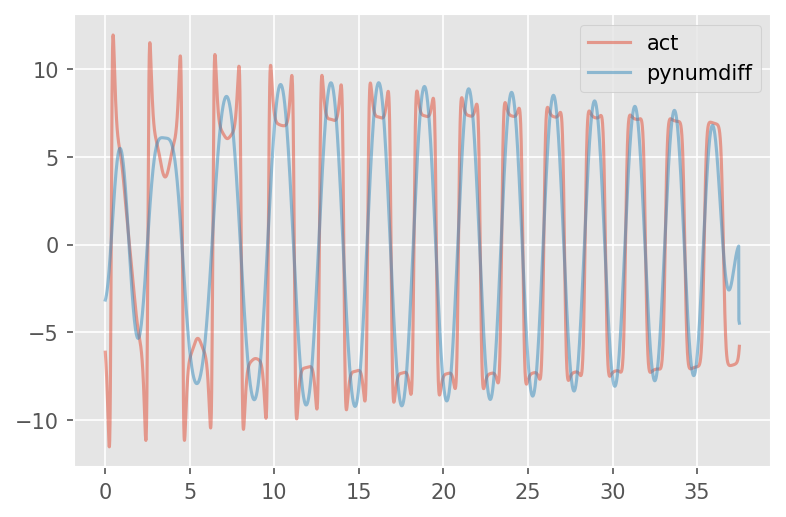

,act,pynumdiff
act,1.00,0.89
pynumdiff,0.89,1.00


In [68]:
set_id = 1
var = "theta"

# Get points per set
dp = params["data_gen_params"]
pps = round((dp["tspan"][1] - dp["tspan"][0]) / dp["dt"] * params["train_cutoff"])
t = np.linspace(dp["tspan"][0], pps * dp["dt"], pps)

# Get mask
mask = np.zeros(model.x.shape[0], dtype=bool)
mask[set_id * pps: (set_id + 1) * pps] = True

# Make predictions
preds = model.predict(model.x, alpha=0.5, smooth=False)
pl = [0.1, 0.5, 0.9]
pred_dict = {
    f"model_{pll}": model.predict(model.x, alpha=pll, smooth=False)[mask, idx] / dp["dt"]
    for pll in pl
}

# Combine in one df
idx = ["theta", "x"].index(var)
true_data = sims.loc[sims.true_data & (sims.set_id == set_id), ["t", "theta", "x"]].groupby("t").mean()
tmp = pd.DataFrame({
    "act": true_data.loc[:t.max(), var].to_numpy(),
    "pynumdiff": model.d2[mask, idx] / dp["dt"],
    # "model": preds[mask, idx] / dp["dt"],
}, index=t)
# } | pred_dict, index=t)

# Plot
fig, ax = plt.subplots(dpi=150)
tmp.plot(ax=ax, alpha = 0.5)
plt.show()

# Correlations
tmp.corr().style.background_gradient(axis=None).format(precision=2)


In [88]:
# Create grid of points to understand model predictions
rng = np.random.default_rng()

n = 100000
grid_df = pd.DataFrame({
    "theta": rng.uniform(0, 7, size=n),
    # "x": rng.uniform(-5, 5, size=n),
    "theta_d": rng.uniform(-7, 7, size=n),
    "x_d": rng.uniform(-2, 2, size=n),
    "alpha": 0.9,
})

# Make predictions from model
grid_df["pred"] = model.models[0].predict(grid_df[["theta", "alpha"]].to_numpy())

# Estimate actual
p = params["data_gen_params"]["de_params"]
grid_df["act"] = params["dt"] * (
    (p["mc"] + p["mp"]) * 9.8 * np.sin(grid_df.theta)
    - np.cos(grid_df.theta)
    * (
        0
        + p["mp"] * p["len"] * (grid_df.theta_d ** 2) * np.sin(grid_df.theta)
        - p["mu_c"] * grid_df.x_d
    )
    - ((p["mc"] + p["mp"]) * p["mu_p"] * grid_df.theta_d) / (p["mp"] * p["len"])
) / (
    (p["mc"] + p["mp"]) * (p["k"] + 1) * p["len"]
    - p["mp"] * p["len"] * (np.cos(grid_df.theta)) ** 2
)


<AxesSubplot:xlabel='theta_rnd'>

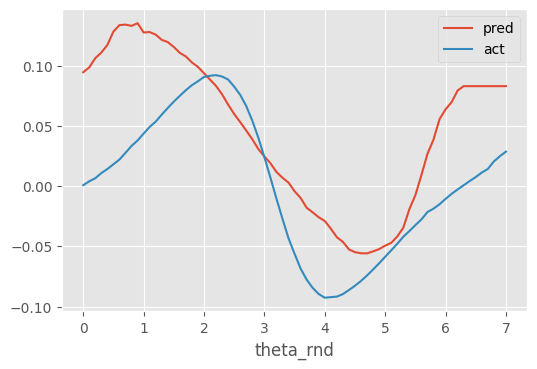

In [89]:
# Show values
x = "theta"

fig, ax = plt.subplots(dpi=100)
grid_df[f"{x}_rnd"] = grid_df[x].round(1)
grid_df.groupby(f"{x}_rnd")[["pred", "act"]].mean().sort_index().plot(ax=ax)

<AxesSubplot:xlabel='act_rnd'>

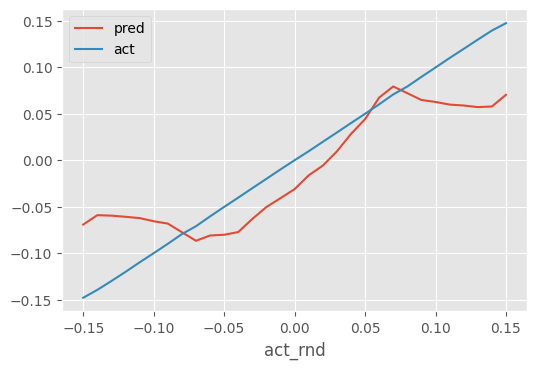

In [46]:
# Show values
x = "theta"
# x = "theta_d"
x = "act"

fig, ax = plt.subplots(dpi=100)
grid_df[f"{x}_rnd"] = grid_df[x].round(2)
grid_df.groupby(f"{x}_rnd")[["pred", "act"]].mean().sort_index().plot(ax=ax)

<AxesSubplot:xlabel='pred', ylabel='act'>

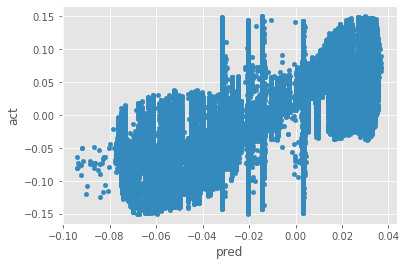

In [94]:
grid_df.plot.scatter(x="pred", y="act")

## Inspect Smoothing

<AxesSubplot:xlabel='t'>

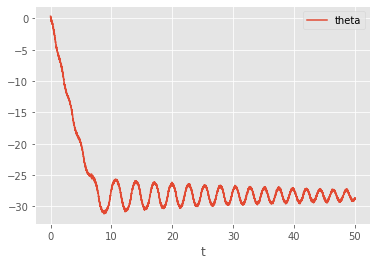

In [113]:
sims.loc[(~sims.sim) & (sims.valid_id == 0), ["t", "theta"]].plot(x="t", y="theta")


<AxesSubplot:>

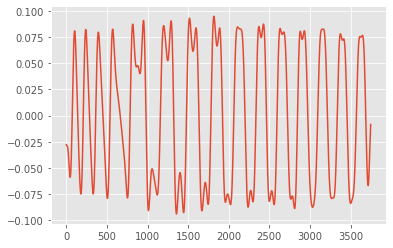

In [97]:
pd.Series(model.d2[:, 0]).plot()

<AxesSubplot:>

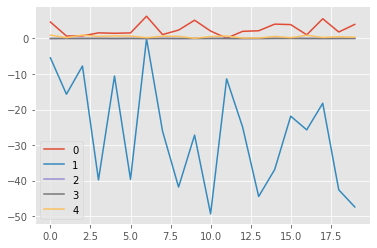

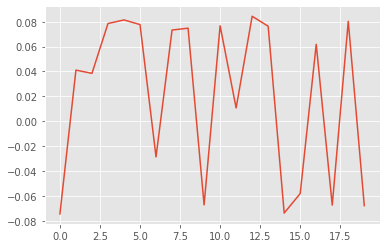

In [95]:
s = 1000
pd.DataFrame(model.x_train[s:s+20]).plot()
fig, ax = plt.subplots()
pd.Series(model.y_train[s:s+20, 0]).plot(ax=ax)